# Bike Sharing Dataset using Decision Tree Regressor
* Based on Bike Sharing dataset from UCI Machine Learning Repository
* This notebook is based upon the hourly data file, i.e. hour.csv
* This notebook showcases regression using Decision Trees

## Problem Statement
Given the Bike Sharing dataset with hourly level information of bikes along with weather and other attributes, model a system which can predict the bike count.

# Import required packages

In [1]:
%matplotlib inline

# data manuipulation
import numpy as np
import pandas as pd

# modeling utilities
import pydotplus 
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sn


sn.set_style('whitegrid')
sn.set_context('talk')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

# Load Dataset

In [2]:
df = pd.read_csv('../data/hour.csv')
print("Shape of dataset::{}".format(df.shape))

Shape of dataset::(17379, 17)


# Preprocessing
* Standarize column names
* Typecast attributes
* Encode Categoricals using One Hot Encoding

# Standarize Column Names

In [3]:
df.rename(columns={'instant':'rec_id',
                        'dteday':'datetime',
                        'holiday':'is_holiday',
                        'workingday':'is_workingday',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_count',
                        'hr':'hour',
                        'yr':'year'},inplace=True)

# Typecast Attributes

In [4]:
# date time conversion
df['datetime'] = pd.to_datetime(df.datetime)

# categorical variables
df['season'] = df.season.astype('category')
df['is_holiday'] = df.is_holiday.astype('category')
df['weekday'] = df.weekday.astype('category')
df['weather_condition'] = df.weather_condition.astype('category')
df['is_workingday'] = df.is_workingday.astype('category')
df['month'] = df.month.astype('category')
df['year'] = df.year.astype('category')
df['hour'] = df.hour.astype('category')

# Encode Categoricals (One Hot Encoding)

In [5]:
def fit_transform_ohe(df,col_name):
    """This function performs one hot encoding for the specified
        column.

    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        col_name: the column to be one hot encoded

    Returns:
        tuple: label_encoder, one_hot_encoder, transformed column as pandas Series

    """
    # label encode the column
    le = preprocessing.LabelEncoder()
    le_labels = le.fit_transform(df[col_name])
    df[col_name+'_label'] = le_labels
    
    # one hot encoding
    ohe = preprocessing.OneHotEncoder()
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return le,ohe,features_df

# given label encoder and one hot encoder objects, 
# encode attribute to ohe
def transform_ohe(df,le,ohe,col_name):
    """This function performs one hot encoding for the specified
        column using the specified encoder objects.

    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        le(Label Encoder): the label encoder object used to fit label encoding
        ohe(One Hot Encoder): the onen hot encoder object used to fit one hot encoding
        col_name: the column to be one hot encoded

    Returns:
        tuple: transformed column as pandas Series

    """
    # label encode
    col_labels = le.transform(df[col_name])
    df[col_name+'_label'] = col_labels
    
    # ohe 
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return features_df

# Train-Test Split

In [6]:
X, X_test, y, y_test = train_test_split(df.iloc[:,0:-3], df.iloc[:,-1], 
                                                    test_size=0.33, random_state=42)

X.reset_index(inplace=True)
y = y.reset_index()

X_test.reset_index(inplace=True)
y_test = y_test.reset_index()

print("Training set::{}{}".format(X.shape,y.shape))
print("Testing set::{}".format(X_test.shape))

Training set::(11643, 15)(11643, 2)
Testing set::(5736, 15)


In [7]:
cat_attr_list = ['season','is_holiday',
                 'weather_condition','is_workingday',
                 'hour','weekday','month','year']
numeric_feature_cols = ['temp','humidity','windspeed','hour','weekday','month','year']
subset_cat_features =  ['season','is_holiday','weather_condition','is_workingday']

In [8]:
encoded_attr_list = []
for col in cat_attr_list:
    return_obj = fit_transform_ohe(X,col)
    encoded_attr_list.append({'label_enc':return_obj[0],
                              'ohe_enc':return_obj[1],
                              'feature_df':return_obj[2],
                              'col_name':col})

In [9]:
feature_df_list = [X[numeric_feature_cols]]
feature_df_list.extend([enc['feature_df'] \
                        for enc in encoded_attr_list \
                        if enc['col_name'] in subset_cat_features])

train_df_new = pd.concat(feature_df_list, axis=1)
print("Shape::{}".format(train_df_new.shape))

Shape::(11643, 19)


# Decision Tree based Regression

In [10]:
X = train_df_new
y= y.total_count.values.reshape(-1,1)

In [11]:
X.shape,y.shape

((11643, 19), (11643, 1))

# Node Splitting
* **Mean Squared Error (MSE)**: Used mainly for regression trees, it is calculated as the square of difference between observed and predicted values.
* **Mean Absolute Error**: Used for regression trees, it is similar to MSE though we only use the difference between the observed and predicted values.
* **Variance Reduction**: This was first introduced with CART algorithm, and it uses the standard formula of variance and we choose the split that results in least variance.
* **Gini Impurity/Index**: Mainly used by classification trees, it is a measure of a randomly chosen data point to have an incorrect label given it was labeled randomly.
* **Information Gain**: Again used mainly for classification problems, it is also termed as entropy. We choose the splits based on the amount of information gain. The higher information gain, the better it is.

# Decision Tree Alogrithms
* CART or Classification And Regression Tree
* ID3 or Iterative Dichotomizer 3
* C4.5

# Sample Decision Tree Regressor

In [12]:
dtr = DecisionTreeRegressor(max_depth=4,
                            min_samples_split=5,
                            max_leaf_nodes=10)
dtr.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=10, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [13]:
dtr.score(X,y)

0.60565765621037793

## Plot the Learnt Model

In [14]:
dot_data = tree.export_graphviz(dtr, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
graph.write_pdf("bikeshare.pdf")

True

## Grid Search With Cross Validation

In [15]:
param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100, 500, 800],
              }

In [17]:
grid_cv_dtr = GridSearchCV(dtr, param_grid, cv=5,n_jobs=-1)

In [18]:
grid_cv_dtr.fit(X,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=10, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'criterion': ['mse', 'mae'], 'min_samples_split': [10, 20, 40], 'max_depth': [2, 6, 8], 'min_samples_leaf': [20, 40, 100], 'max_leaf_nodes': [5, 20, 100, 500, 800]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

## Cross Validation: Best Model Details

In [19]:
print("R-Squared::{}".format(grid_cv_dtr.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_dtr.best_params_))

R-Squared::0.85891903233008
Best Hyperparameters::
{'criterion': 'mse', 'max_depth': 8, 'max_leaf_nodes': 500, 'min_samples_leaf': 20, 'min_samples_split': 20}


In [20]:
df = pd.DataFrame(data=grid_cv_dtr.cv_results_)
df.head()

/Users/wunlung/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/wunlung/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/wunlung/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/wunlung/anaconda3/li

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_criterion,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.024563,0.005668,0.48401,0.48875,mse,2,5,20,10,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",...,0.486478,0.48915,0.475286,0.491167,0.491096,0.487932,0.002919,0.001618,0.007223,0.002883
1,0.027609,0.004640,0.48401,0.48875,mse,2,5,20,20,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",...,0.486478,0.48915,0.475286,0.491167,0.491096,0.487932,0.003733,0.000683,0.007223,0.002883
2,0.022020,0.004086,0.48401,0.48875,mse,2,5,20,40,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",...,0.486478,0.48915,0.475286,0.491167,0.491096,0.487932,0.001833,0.000199,0.007223,0.002883
3,0.020442,0.003865,0.48401,0.48875,mse,2,5,40,10,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",...,0.486478,0.48915,0.475286,0.491167,0.491096,0.487932,0.001183,0.000116,0.007223,0.002883
4,0.020577,0.003448,0.48401,0.48875,mse,2,5,40,20,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",...,0.486478,0.48915,0.475286,0.491167,0.491096,0.487932,0.000334,0.000342,0.007223,0.002883


[Text(0.5,1,'Effect of Depth and Leaf Nodes on Model Performance')]

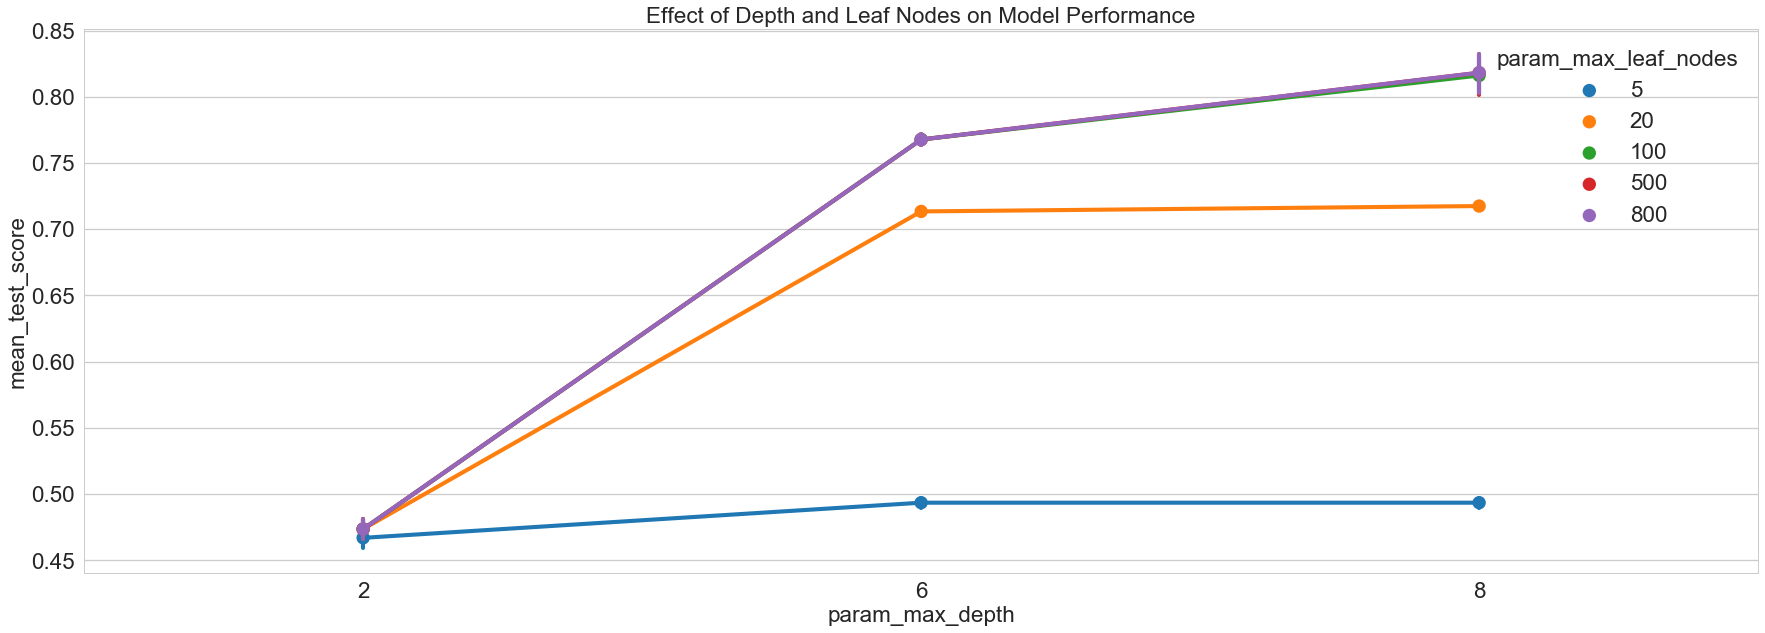

In [21]:
fig,ax = plt.subplots()
sns.pointplot(data=df[['mean_test_score',
                           'param_max_leaf_nodes',
                           'param_max_depth']],
             y='mean_test_score',x='param_max_depth',
             hue='param_max_leaf_nodes',ax=ax)
ax.set(title="Effect of Depth and Leaf Nodes on Model Performance")

# Residual Plot

In [22]:
predicted = grid_cv_dtr.best_estimator_.predict(X)
residuals = y.flatten()-predicted

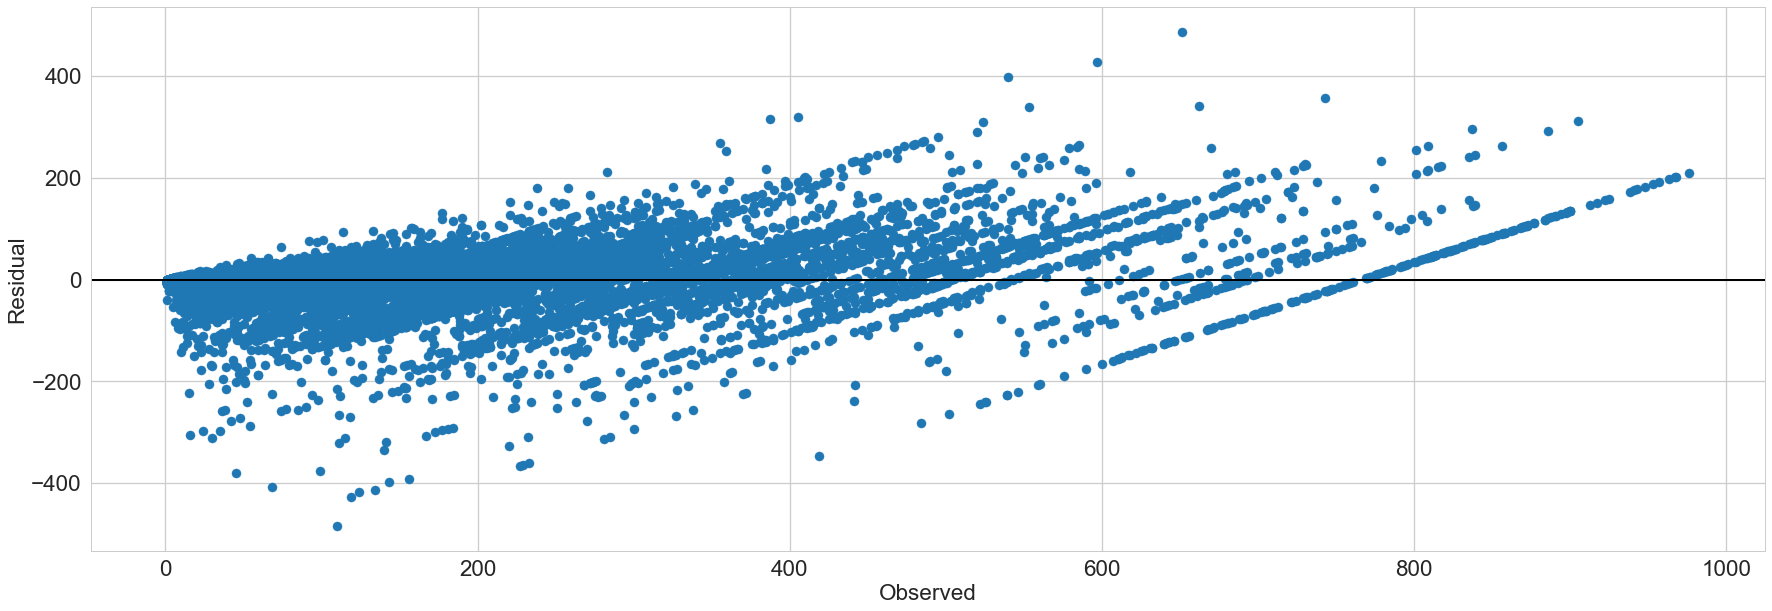

In [23]:
fig, ax = plt.subplots()
ax.scatter(y.flatten(), residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

In [24]:
r2_scores = cross_val_score(grid_cv_dtr.best_estimator_, X, y, cv=10)
mse_scores = cross_val_score(grid_cv_dtr.best_estimator_, X, y, cv=10,scoring='neg_mean_squared_error')

In [25]:
print("avg R-squared::{}".format(np.mean(r2_scores)))
print("MSE::{}".format(np.mean(mse_scores)))

avg R-squared::0.8634248558271074
MSE::-4546.657848020102


In [26]:
best_dtr_model = grid_cv_dtr.best_estimator_

# Test Dataset Performance

In [27]:
test_encoded_attr_list = []
for enc in encoded_attr_list:
    col_name = enc['col_name']
    le = enc['label_enc']
    ohe = enc['ohe_enc']
    test_encoded_attr_list.append({'feature_df':transform_ohe(X_test,le,ohe,col_name),
                                   'col_name':col_name})
    
    
test_feature_df_list = [X_test[numeric_feature_cols]]
test_feature_df_list.extend([enc['feature_df'] for enc in test_encoded_attr_list if enc['col_name'] in subset_cat_features])

test_df_new = pd.concat(test_feature_df_list, axis=1) 
print("Shape::{}".format(test_df_new.shape))

Shape::(5736, 19)


In [28]:
X_test = test_df_new
y_test = y_test.total_count.values.reshape(-1,1)

In [29]:
y_pred = best_dtr_model.predict(X_test)
residuals = y_test.flatten() - y_pred

In [30]:
r2_score = best_dtr_model.score(X_test,y_test)
print("R-squared::{}".format(r2_score))
print("MSE: %.2f"
      % metrics.mean_squared_error(y_test, y_pred))

R-squared::0.8722059567160857
MSE: 4076.82


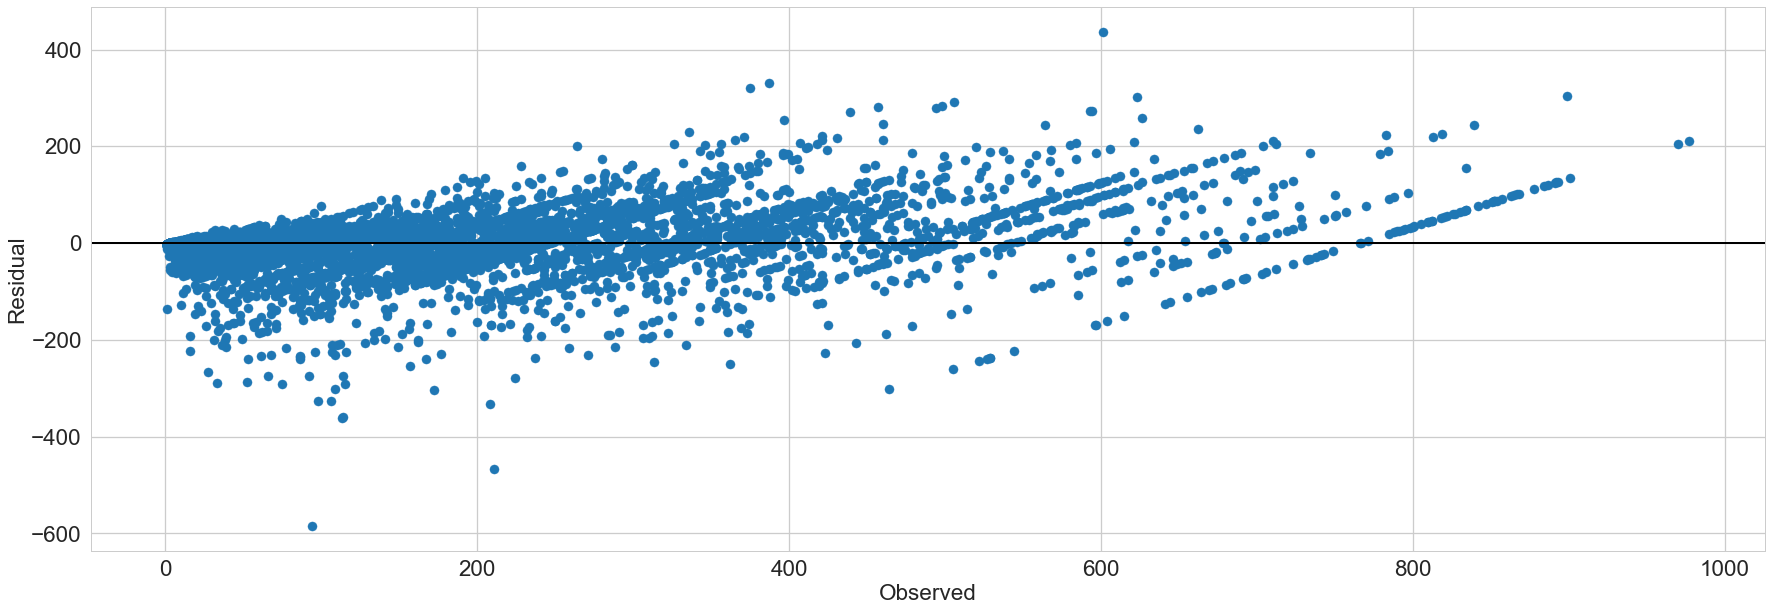

In [31]:
fig, ax = plt.subplots()
ax.scatter(y_test.flatten(), residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

r2_score = grid_cv_dtr.best_estimator_.score(X_test,y_test)